In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, MixUpCallback
from fastai.callback import *
from google.colab import drive

from torch.utils.data.sampler import WeightedRandomSampler

In [3]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/My Drive/')

Mounted at /content/drive


In [0]:
path = Path('/content/drive/My Drive/burn')


# Assemble data for training

In [0]:
labels3july = pd.read_csv(path/'labels3july.csv')

In [6]:
labels3july.head()

,file_name,label
0,images/BurnPhotos88_8.jpg,3+
1,images/BurnPhotos6_BurnPhotos555_8.jpg,3+
2,images/BurnPhotos82_4.jpg,2
3,images/BurnPhotos6_BurnPhotos576_5.jpg,3+
4,images/75.jpg,3+


In [0]:
bs = 64
size = 256

In [0]:
il = ImageList.from_df(labels3july, path, cols='file_name') # ImageList
sd = il.split_by_rand_pct(0.2, seed=42) # ItemLists
ld = sd.label_from_df(cols='label') # LabelLists

In [0]:
transforms = get_transforms(flip_vert=True,
                           max_rotate=30.,
                           max_zoom=2.,
                           max_lighting=0.5,
                           max_warp=0.5,
                           xtra_tfms=[cutout()])

In [0]:
ll = ld.transform(tfms=transforms, size=size) # LabelLists
data = ll.databunch(bs=bs, num_workers=2).normalize(imagenet_stats)

In [0]:
class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner, weights:torch.Tensor=None):
        super().__init__(learn)
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels,return_counts=True)
        self.weights = (weights if weights is not None else
                        torch.DoubleTensor((1/counts)[self.labels]))

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,len(self.learn.data.train_dl.dataset)), self.learn.data.train_dl.batch_size,False) 

# Training:

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy]).to_fp16()

In [19]:
learn.load('wg_123_12jul_mixup_b')
accuracy(*learn.get_preds())

tensor(0.8466)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


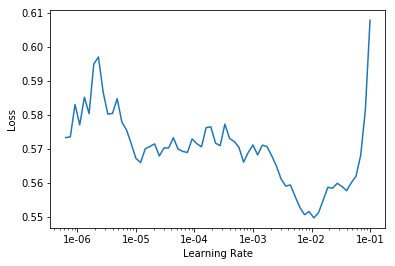

In [16]:
learn.recorder.plot(skip_end=10)

In [22]:
learn.fit_one_cycle(200, 3e-3, callbacks=[OverSamplingCallback(learn),
                                           MixUpCallback(learn),
                                          SaveModelCallback(learn, monitor='accuracy', name='wg_123_12jul_mixup')])

epoch,train_loss,valid_loss,accuracy,time
0,0.681636,0.452868,0.837061,00:32
1,0.685565,0.459111,0.837061,00:33
2,0.674259,0.457557,0.830671,00:33
3,0.679175,0.456865,0.830671,00:33
4,0.675710,0.466750,0.811502,00:33
5,0.673667,0.463547,0.824281,00:33
6,0.670741,0.463979,0.814696,00:32
7,0.667028,0.468819,0.808307,00:31
8,0.666592,0.474774,0.808307,00:33
9,0.665975,0.464957,0.814696,00:33


Better model found at epoch 0 with accuracy value: 0.8370606899261475.
Better model found at epoch 19 with accuracy value: 0.8434504866600037.


RuntimeError: ignored